**Import Library**

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 13.0 MB/s eta 0:00:00


In [2]:
import pandas as pd # manipulasi dan analisis data
pd.options.mode.chained_assignment = None # menonaktifkan peringatan chaining

import numpy as np # komputasi numerik
seed = 0
np.random.seed(seed) # mengatur untuk reproduktibilitas

import matplotlib.pyplot as plt # visualisasi data
import seaborn as sns # visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import datetime as dt # manipulasi data dan tanggal
import re # modul untuk bekerja dengan ekspresi reguler
import string # konstanta string

import nltk # pustaka natural language toolkit
nltk.download('stopwords') # dataset untuk tokenisasi teks
nltk.download('punkt_tab') # dataset daftar kata kata berhenti dalam berbagai bahasa
from nltk.tokenize import word_tokenize # tokenisasi teks
from nltk.corpus import stopwords # daftar kata kata berhenti dalam teks

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # stemming penghilangan imbuhan kata dalam bahasa indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory # menghapus kata kata berhenti dalam bahasa indonesia

from sklearn.linear_model import  LogisticRegression # modeling logistic regression
from sklearn.ensemble import RandomForestClassifier # modeling random forest

from sklearn.preprocessing import LabelEncoder # labeling encoding

from sklearn.model_selection import train_test_split # digunakan untuk splitting dataset

from sklearn.feature_extraction.text import TfidfVectorizer # ekstrasi fitur TF-ID
from sklearn.feature_extraction.text import CountVectorizer # ekstraksi fitur BoW

from wordcloud import WordCloud # visualisasi awan kata dari teks

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**Loading Dataset**

In [3]:
# import file dataset dari scraping
df = pd.read_csv('/content/shopeepay_reviews4.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,73efad04-d4a4-4b4d-800b-a4d015d6d4bd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi ini bagus & bermanfaat.,5,0,NaN,2025-10-22 21:33:19,Hi Kak. Terima kasih telah menggunakan ShopeeP...,2025-10-23 02:32:24,NaN
1,3fe73e09-049c-4697-b8a2-9aef385e04f8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ok,5,0,NaN,2025-10-22 21:29:40,Hi Kak. Terima kasih telah menggunakan ShopeeP...,2025-10-23 02:29:38,NaN
2,b118417c-7bcf-4f30-a737-529bead4ee45,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,iklan anj,1,0,NaN,2025-10-22 20:59:46,"Hi Kak, Mohon maaf atas ketidaknyamanannya. Sa...",2025-10-23 03:48:06,NaN
3,f931d492-7f17-485d-be1f-330b38700d56,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat mempermudah,5,0,1.41.06,2025-10-22 20:51:44,Hi Kak. Terima kasih telah menggunakan ShopeeP...,2025-10-23 02:31:53,1.41.06
4,b88efd4d-d830-4076-8d30-5b0bb3f66554,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Good,5,0,NaN,2025-10-22 20:30:50,Hi Kak. Terima kasih telah menggunakan ShopeeP...,2025-10-23 02:32:01,NaN


In [4]:
# menampilkan informasi dataset hasil scraping
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              25000 non-null  object
 1   userName              25000 non-null  object
 2   userImage             25000 non-null  object
 3   content               25000 non-null  object
 4   score                 25000 non-null  int64 
 5   thumbsUpCount         25000 non-null  int64 
 6   reviewCreatedVersion  20171 non-null  object
 7   at                    25000 non-null  object
 8   replyContent          24855 non-null  object
 9   repliedAt             24855 non-null  object
 10  appVersion            20171 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.1+ MB


In [5]:
# mengecek data duplikat
duplicate = df.duplicated()
print(duplicate.sum())

0


In [6]:
# mengeliminasi kolom selain username, content, score
clean_df = df[['userName', 'content', 'score']]

In [7]:
# menampilkan informasi dataset hasil cleaning
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  25000 non-null  object
 1   content   25000 non-null  object
 2   score     25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


**Preprocessing Text**

In [8]:
def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
  text = re.sub(r'RT[\s]', '', text) # menghapus RT
  text = re.sub(r"http\S+", '', text) # menghapus link
  text = re.sub(r'[0-9]+', '', text) # menghapus angka
  text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

  text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
  text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
  text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
  return text

def casefoldingText(text): # mengubah semua karakter dalam teks menjadi huruf kecil
  text = text.lower()
  return text

def tokenizingText(text): # memecah atau membagi string, teks menjadi daftar token
  text = word_tokenize(text)
  return text

def filteringText(text): # mengubah stopwords dalam teks
  listStopwords = set(stopwords.words('indonesian'))
  listStopwords1 = set(stopwords.words('english'))
  listStopwords.update(listStopwords1)
  listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", 'gk', 'cuy', 'dih', 'beuh', 'eee', 'heee', 'nih', 'nihh', 'dong', 'mulu', 'mah', ])
  filtered = []
  for txt in text:
    filtered.append(txt)
    text = filtered
  return text

def stemmingText(text): # mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
  factory = StemmerFactory() # membuat objek stemmer
  stemmer = factory.create_stemmer()

  words = text.split() # memecah teks menjadi daftar kata

  stemmed_words = [stemmer.stem(word) for word in words] # menerapkan stemmeing setiap kata dalam daftar

  stemmed_text = ' '.join(stemmed_words) # menggabungkan kata-kata yang telah di stemming menjadi teks baru

  return stemmed_text

def toSentence(list_words): # mengubah daftar kata menjadi kalimat
  sentence = ' '.join(word for word in list_words)
  return sentence

In [9]:
slangwords = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat",
"sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def fix_slangwords(text):
  words = text.split()
  fixed_words = []

  for word in words:
    if word.lower() in slangwords:
      fixed_words.append(slangwords[word.lower()])
    else:
      fixed_words.append(word)

  fixed_text = ' '.join(fixed_words)
  return fixed_text


In [10]:
# membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [11]:
# menampilkan dataset yang sudah melalui preprocessing
clean_df

,userName,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,aplikasi ini bagus & bermanfaat.,5,aplikasi ini bagus bermanfaat,aplikasi ini bagus bermanfaat,aplikasi ini bagus bermanfaat,"[aplikasi, ini, bagus, bermanfaat]","[aplikasi, ini, bagus, bermanfaat]",aplikasi ini bagus bermanfaat
1,Pengguna Google,ok,5,ok,ok,ok,[ok],[ok],ok
2,Pengguna Google,iklan anj,1,iklan anj,iklan anj,iklan anj,"[iklan, anj]","[iklan, anj]",iklan anj
3,Pengguna Google,sangat mempermudah,5,sangat mempermudah,sangat mempermudah,sangat mempermudah,"[sangat, mempermudah]","[sangat, mempermudah]",sangat mempermudah
4,Pengguna Google,Good,5,Good,good,good,[good],[good],good
...,...,...,...,...,...,...,...,...,...
24995,Pengguna Google,aman lancar terpercaya,5,aman lancar terpercaya,aman lancar terpercaya,aman lancar terpercaya,"[aman, lancar, terpercaya]","[aman, lancar, terpercaya]",aman lancar terpercaya
24996,Pengguna Google,blm ada pengalaman saya baru pakek aplikasi ini,5,blm ada pengalaman saya baru pakek aplikasi ini,blm ada pengalaman saya baru pakek aplikasi ini,belum ada pengalaman saya baru pakek aplikasi ini,"[belum, ada, pengalaman, saya, baru, pakek, ap...","[belum, ada, pengalaman, saya, baru, pakek, ap...",belum ada pengalaman saya baru pakek aplikasi ini
24997,Pengguna Google,good,5,good,good,good,[good],[good],good
24998,Pengguna Google,bagus,5,bagus,bagus,bagus,[bagus],[bagus],bagus


**Pelabelan**

In [12]:
import csv
import requests
from io import StringIO

# membaca data kamus kata kata positif dari Github
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

# mengirim permintaan HTTP untuk mendapatkan file csv dari Github
if response.status_code == 200:
  # jika permintaan berhasil
  reader = csv.reader(StringIO(response.text), delimiter=',')
  # membaca teks respon sebagai file csv menggunakan pembaca csv dengan pemisah koma
  for row in reader:
    # mengulangi setiap baris dalam file csv
    lexicon_positive[row[0]] = int(row[1])
    # menambahkan kata kata positif dan skornya ke dalam kamus lexicon_positive
else:
  print("Failed to fetch positive lexicon data")

# membaca data kamus kata kata negatif dari github
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

# mengirim permintaan HTTP untuk mendapatkan file csv dari Github
if response.status_code == 200:
  # jika permintaan berhasil
  reader = csv.reader(StringIO(response.text), delimiter=',')
  # membaca teks respon sebagai file csv menggunakan pembaca csv dengan pemisah koma
  for row in reader:
    # mengulangi setiap baris dalam file csv
    lexicon_negative[row[0]] = int(row[1])
    # menambahkan kata kata positif dan skornya ke dalam kamus lexicon_positive
else:
  print("Failed to fetch negative lexicon data")

In [13]:
# fungsi untuk menentukan polaritas sentimen dari reviews
def sentiment_analysis_lexicon_indonesia(text):
  score = 0 # inisialisasi skor sentimen 0
  for word in text: # mengulangi setiap kata dalam teks
    if (word in lexicon_positive):
      score = score + lexicon_positive[word] # jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

  for word in text:
    if (word in lexicon_negative):
      score = score + lexicon_negative[word]# jika kata ada dalam kamus negatif, tambahkan skornya ke skor sentimen

  polarity='' # inisilisasi variabel polaritas

  if (score > 0):
    polarity = 'positive' # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
  elif (score < 0):
    polarity = 'negative' # Jika skor sentimen lebih kecil 0, maka polaritas adalah negatif
  else:
    polarity = 'neutral' # Jika skor sentimen sama dengan 0, maka polaritas adalah neutral

  return score, polarity # mengembalikan skor sentimen dan polaritas teks

In [14]:
# menampilkan hasil pelabelan yang dibagi tiga kela (positif, netral, negatif)
results  = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    10968
negative     9894
neutral      4138
Name: count, dtype: int64


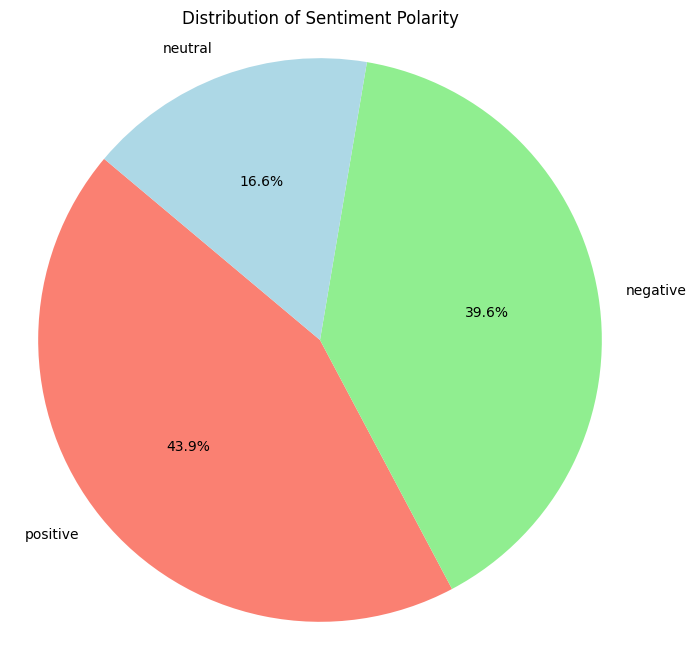

In [15]:
# mendapatkan jumalh setiap polaritas
polarity_counts = clean_df['polarity'].value_counts()

# membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140, colors=['salmon', 'lightgreen', 'lightblue'])
plt.title('Distribution of Sentiment Polarity')
plt.axis('equal')
plt.show()

**Eksplorasi Label**

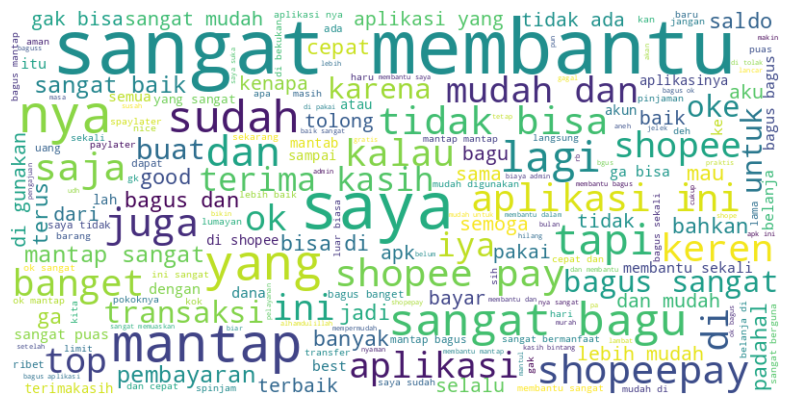

In [16]:
# menggabungkan semua data teks yang telah dibersihkan menjadi satu string
all_text = " ".join(review for review in clean_df['text_akhir'])

# membuat objek wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# menampilkan wordcloud yang dihasilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

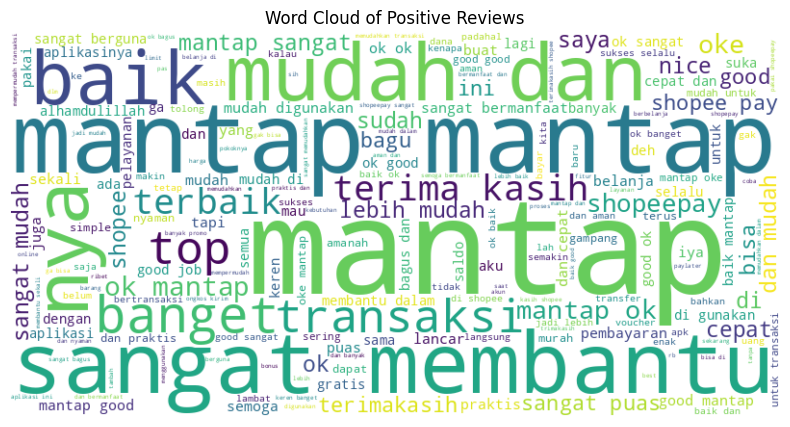

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# filter dataframe untuk ulasan positif
positive_reviews_df = clean_df[clean_df['polarity'] == 'positive']

# menggabungkan semua data teks yang dibersihkan dari ulasan positif menjadi satu string
positive_text = " ".join(review for review in positive_reviews_df['text_akhir'])

# membuat objek wordcloud untuk ulasan positif
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# menampilkan wordcloud yang dihasilkan untuk ulasan positif
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Reviews")
plt.show()

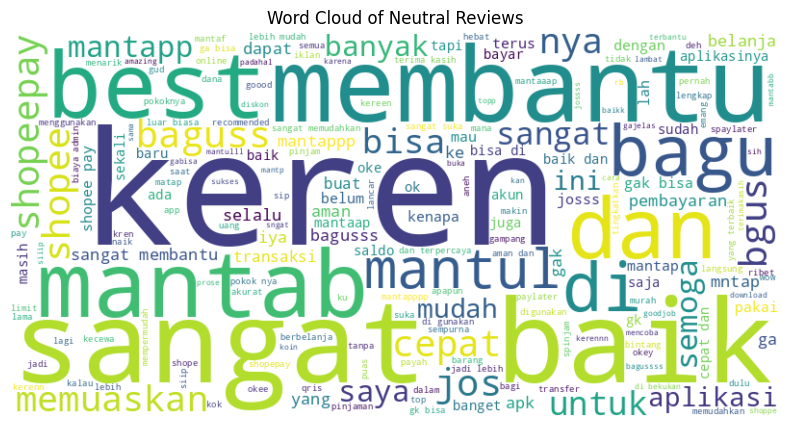

In [18]:
# filter dataframe untuk ulasan netral
neutral_reviews_df = clean_df[clean_df['polarity'] == 'neutral']

# menggabungkan semua data teks yang dibersihkan dari ulasan netral menjadi satu string
neutral_text = " ".join(review for review in neutral_reviews_df['text_akhir'])

# membuat objek wordcloud untuk ulasan netral
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# menampilkan wordcloud yang dihasilkan untuk ulasan netral
plt.figure(figsize=(10, 5))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Reviews")
plt.show()

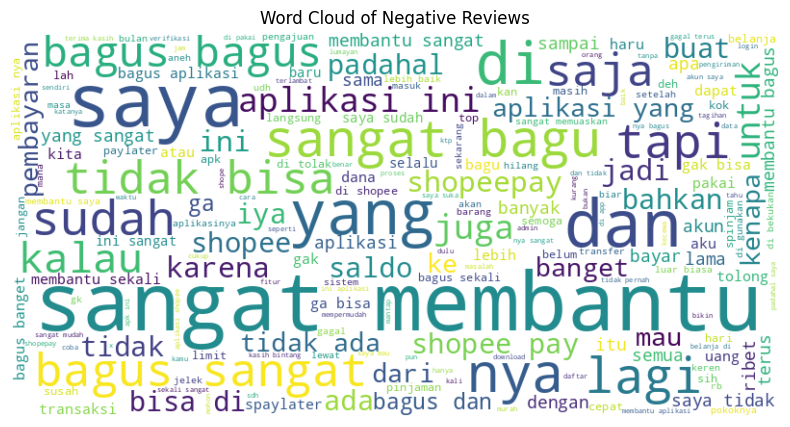

In [19]:
# filter dataframe untuk ulasan negatif
negative_reviews_df = clean_df[clean_df['polarity'] == 'negative']

# menggabungkan semua data teks yang dibersihkan dari ulasan negatif menjadi satu string
negative_text = " ".join(review for review in negative_reviews_df['text_akhir'])

# membuat objek wordcloud untuk ulasan negatif
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# menampilkan wordcloud yang dihasilkan untuk ulasan negatif
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Reviews")
plt.show()

**Data Splitting**

In [20]:
# mengambil data X dan Y
X = clean_df['text_akhir']
y = clean_df['polarity']

# mengencoding label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [21]:
# membagi data menjadi 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

**Ekstraksi Fitur**

In [22]:
# ekstraksi fitur TF-ID
tfidf = TfidfVectorizer(max_features=250, min_df=20, max_df=0.8)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# konversi dataframe
X_train_df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())
X_test_df_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [23]:
# ekstraksi fitur BoW
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform((X_test))

# konversi dataframe
X_train_df_bow = pd.DataFrame(X_train_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
X_test_df_bow = pd.DataFrame(X_test_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

**Evaluasi**

In [24]:
# model evaluasi
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # evaluasi data latih
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # evaluasi data uji
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # menampilkan hasil
    print(f"Evaluasi Model {model}")
    print(f"Accuracy train: {accuracy_train:.4f}")
    print(f"Accuracy test: {accuracy_test}")

**Model**

In [25]:
# model logisticregression + ekstraksi bow
lr_bow = LogisticRegression(class_weight='balanced')
lr_bow.fit(X_train_df_bow, y_train)

evaluate_model(lr_bow, X_train_df_bow, y_train, X_test_df_bow, y_test)

Evaluasi Model LogisticRegression(class_weight='balanced')
Accuracy train: 0.9635
Accuracy test: 0.9258


In [26]:
# model logisticregression + ekstraksi tfidf
lr2 = LogisticRegression(class_weight='balanced')
lr2.fit(X_train_df_tfidf, y_train)

evaluate_model(lr2, X_train_df_tfidf, y_train, X_test_df_tfidf, y_test)

Evaluasi Model LogisticRegression(class_weight='balanced')
Accuracy train: 0.9123
Accuracy test: 0.91


In [27]:
# model randomforest + ekstraksi bow
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_df_bow, y_train)

evaluate_model(rf, X_train_df_bow, y_train, X_test_df_bow, y_test)

Evaluasi Model RandomForestClassifier(class_weight='balanced')
Accuracy train: 1.0000
Accuracy test: 0.9214


In [28]:
# model randomforest + ekstraksi tfidf
rf2 = RandomForestClassifier(class_weight='balanced')
rf2.fit(X_train_df_tfidf, y_train)

evaluate_model(rf2, X_train_df_tfidf, y_train, X_test_df_tfidf, y_test)

Evaluasi Model RandomForestClassifier(class_weight='balanced')
Accuracy train: 0.9760
Accuracy test: 0.9052


**Inference**

In [29]:
# ulasan baru inferensi
new_reviews = ["transaksi cepat dan mantap", "saya mengalami masalah saat melakukan pembayaran.", "fitur baru ini membantu"]

# preprosessing ulasan baru
processed_new_reviews = [toSentence(filteringText(tokenizingText(fix_slangwords(casefoldingText(cleaningText(review)))))) for review in new_reviews]

# mengubah ulasan baru menggunakan BoW
new_reviews_bow = bow_vectorizer.transform(processed_new_reviews)

# membuat prediksi menggunakan randomforest + bow
predictions_encoded = rf.predict(new_reviews_bow)

# decode ke polarity
predictions = le.inverse_transform(predictions_encoded)

# menampilkan hasil prediksi
for review, polarity in zip(new_reviews, predictions):
    print(f"Review: {review} -> Predicted Polarity: {polarity}")

Review: transaksi cepat dan mantap -> Predicted Polarity: positive
Review: saya mengalami masalah saat melakukan pembayaran. -> Predicted Polarity: negative
Review: fitur baru ini membantu -> Predicted Polarity: neutral


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [30]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.12.0
access==1.1.10.post3
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
aiosqlite==0.22.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2025.12.15.0.40.51
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.6
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.9
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.31.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.1.0
blosc2==3.12.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==6.2.4
catalogue==2.0.10
certifi==2025.11.12
cffi==2.0.0
chardet==5.2.0
cha